In [1]:
# ===========================================================
# 0. 导入包 & 全局配置
# ===========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- 路径按你自己的目录/文件名改 ----
DATA_DIR = Path("./Q1data")

CALENDAR_PATH = DATA_DIR / "20250615-London-calendar.csv"
LISTINGS_PATH = DATA_DIR / "20250615-London-listings.csv"

# Borough 租金 Excel（按 Borough）
RENT_EXCEL_PATH = DATA_DIR / "borough_rent_2024_07_2025_06.xlsx"

# Borough 住房存量 CSV（social landlord）
STOCK_CSV_PATH = DATA_DIR / "social-landlord-housing-stock-borough.csv"

# ---- 阈值设定 ----
VIOLATION_THRESHOLD        = 90     # 90 天规则（政策）
COMMERCIAL_AVAIL_THRESHOLD = 60     # commercial STR（≥60 可用夜）
HOTEL_LIKE_OCC_THRESHOLD   = 180    # hotel-like STR（≥180 占用夜）

CHUNK_SIZE  = 200_000
BOROUGH_COL = "neighbourhood_cleansed"   # 这里把 borough 当作 neighbourhood

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10


# ===========================================================
# 1. 基础：calendar 汇总 / listings 读取 / 合并 / 统一打 flag
# ===========================================================
def summarise_calendar_streaming(
    path: Path,
    chunk_size: int = CHUNK_SIZE,
    start_date: str = "2024-06-15",
    end_date: str   = "2025-06-15",
) -> pd.DataFrame:
    """
    流式读取 calendar.csv，并按 listing_id 汇总：
      - occupied_nights：被占用的夜晚数（available == 'f'）
      - total_nights：有记录的总夜晚数
      - available_nights = total_nights - occupied_nights
      - occupancy_rate   = occupied_nights / total_nights

    只保留 start_date ≤ date < end_date 的记录。
    """
    agg: dict[int, tuple[int, int]] = {}

    for chunk in pd.read_csv(path, chunksize=chunk_size, low_memory=False):
        if not {"listing_id", "available", "date"}.issubset(chunk.columns):
            raise ValueError("calendar 文件必须包含 listing_id, available, date 列")

        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
        chunk = chunk.dropna(subset=["date"])

        mask = (chunk["date"] >= start_date) & (chunk["date"] < end_date)
        chunk = chunk.loc[mask]
        if chunk.empty:
            continue

        chunk["is_occupied"] = chunk["available"].astype(str).str.lower().eq("f")

        grouped = (
            chunk.groupby("listing_id", as_index=False)["is_occupied"]
                 .agg(occupied_nights="sum", total_nights="size")
        )

        for _, row in grouped.iterrows():
            lid = int(row["listing_id"])
            occ = int(row["occupied_nights"])
            tot = int(row["total_nights"])
            if lid in agg:
                prev_occ, prev_tot = agg[lid]
                agg[lid] = (prev_occ + occ, prev_tot + tot)
            else:
                agg[lid] = (occ, tot)

    summary = (
        pd.DataFrame
        .from_dict(agg, orient="index", columns=["occupied_nights", "total_nights"])
        .reset_index()
        .rename(columns={"index": "listing_id"})
    )

    summary["available_nights"] = summary["total_nights"] - summary["occupied_nights"]
    summary["occupancy_rate"]   = summary["occupied_nights"] / summary["total_nights"]

    return summary


def load_listings(path: Path) -> pd.DataFrame:
    """
    只读取后面真要用到的列，减轻内存：
      - id, host_id, room_type
      - neighbourhood_cleansed, neighbourhood_group_cleansed
      - latitude, longitude
      - number_of_reviews
      - price （转成 price_clean）
    """
    cols_in_file = pd.read_csv(path, nrows=0).columns.tolist()

    desired_cols = [
        "id",
        "host_id",
        "room_type",
        "neighbourhood_cleansed",
        "neighbourhood_group_cleansed",
        "latitude",
        "longitude",
        "number_of_reviews",
        "price",
    ]
    usecols = [c for c in desired_cols if c in cols_in_file]

    df = pd.read_csv(path, usecols=usecols, low_memory=False)

    if "price" in df.columns:
        price_str = df["price"].astype(str)
        price_str = price_str.str.replace(r"[^\d.]", "", regex=True)
        df["price_clean"] = pd.to_numeric(price_str, errors="coerce")
    else:
        df["price_clean"] = np.nan

    return df


def merge_calendar_listings(occ_summary: pd.DataFrame,
                            listings: pd.DataFrame) -> pd.DataFrame:
    """
    把每个 listing 的夜晚统计与房源属性、房东信息合并。
    """
    cols_to_keep = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed",
        "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews",
        "price_clean",
    ]
    existing_cols = [c for c in cols_to_keep if c in listings.columns]

    merged = occ_summary.merge(
        listings[existing_cols].drop_duplicates(subset="id"),
        left_on="listing_id",
        right_on="id",
        how="left",
    )
    return merged


def add_core_flags(df: pd.DataFrame) -> pd.DataFrame:
    """
    在同一张 merged 表上一次性打好所有政策/商业/空间都要用的 flag：
      - is_entire_home
      - violates_90day (occupied_nights > 90)
      - commercial_STR (available_nights > 60)
      - hotel_like (occupied_nights > 180)
    """
    df = df.copy()
    df["is_entire_home"] = df["room_type"].eq("Entire home/apt")

    if not {"occupied_nights", "available_nights"}.issubset(df.columns):
        raise ValueError("缺少 occupied_nights 或 available_nights 列。")

    df["violates_90day"] = df["occupied_nights"] > VIOLATION_THRESHOLD
    df["commercial_STR"] = df["available_nights"] > COMMERCIAL_AVAIL_THRESHOLD
    df["hotel_like"]     = df["occupied_nights"] > HOTEL_LIKE_OCC_THRESHOLD

    df["legal_but_commercial"] = (~df["violates_90day"]) & df["commercial_STR"]

    return df


def prepare_merged(start_date: str = "2024-06-15",
                   end_date: str   = "2025-06-15") -> pd.DataFrame:
    """
    一次性准备所有后续分析都会用到的 merged 表：
      calendar 汇总 + listings + 核心 flag。
    """
    print(f"=== Core Step: Summarising calendar {start_date} ~ {end_date} ===")
    occ_summary = summarise_calendar_streaming(
        CALENDAR_PATH,
        chunk_size=CHUNK_SIZE,
        start_date=start_date,
        end_date=end_date,
    )
    print("  Listings with calendar data:", len(occ_summary))

    print("=== Core Step: Loading listings and merging ===")
    listings = load_listings(LISTINGS_PATH)
    merged = merge_calendar_listings(occ_summary, listings)
    merged = add_core_flags(merged)

    # 释放中间对象，防止后面内存吃紧
    del occ_summary
    del listings

    print("  Total listings in merged:", merged["listing_id"].nunique())
    print("  Columns:", list(merged.columns))

    return merged


# ===========================================================
# 2. 政策部分：90 天规则（基于 merged）
# ===========================================================
def citywide_violation_stats(df: pd.DataFrame) -> dict:
    entire = df[df["is_entire_home"]].copy()
    total_entire = entire["listing_id"].nunique()

    n_viol = int(entire["violates_90day"].sum())
    share_viol = n_viol / total_entire if total_entire > 0 else np.nan

    n_comm = int(entire["commercial_STR"].sum())
    share_comm = n_comm / total_entire if total_entire > 0 else np.nan

    overlap = entire[entire["violates_90day"] & entire["commercial_STR"]].shape[0]
    overlap_rate = overlap / n_viol if n_viol > 0 else np.nan

    return {
        "total_entire_homes": int(total_entire),
        "n_violates_90day": n_viol,
        "share_violates_90day": share_viol,
        "n_commercial_entire": n_comm,
        "share_commercial_entire": share_comm,
        "overlap_count": int(overlap),
        "overlap_rate_within_violations": overlap_rate,
    }


def neighbourhood_violation_stats(df: pd.DataFrame) -> pd.DataFrame:
    entire = df[df["is_entire_home"]].copy()
    group_col = BOROUGH_COL

    grouped = (
        entire
        .groupby(group_col)
        .agg(
            n_entire=("listing_id", "nunique"),
            n_violations=("violates_90day", "sum"),
            n_commercial=("commercial_STR", "sum"),
        )
        .reset_index()
    )

    grouped["share_violations"] = grouped["n_violations"] / grouped["n_entire"]
    grouped["share_commercial"] = grouped["n_commercial"] / grouped["n_entire"]

    grouped = grouped.rename(columns={group_col: "borough"})
    return grouped


def plot_occupied_histogram(df: pd.DataFrame) -> None:
    entire = df[df["is_entire_home"]]
    plt.figure()
    plt.hist(entire["occupied_nights"], bins=30)
    plt.axvline(VIOLATION_THRESHOLD, color="red", linestyle="--", label="90-night limit")
    plt.xlabel("Occupied nights (entire homes)")
    plt.ylabel("Number of listings")
    plt.title("Distribution of occupied nights (entire homes)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_top_violation_areas(neigh_stats: pd.DataFrame, top_n: int = 20) -> None:
    df = neigh_stats.sort_values("share_violations", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["share_violations"])
    plt.gca().invert_yaxis()
    plt.xlabel("Share of entire homes violating 90-day rule")
    plt.ylabel("Borough")
    plt.title(f"Top {top_n} boroughs by 90-day rule violation rate")
    plt.tight_layout()
    plt.show()


def plot_share_commercial_vs_violations(neigh_stats: pd.DataFrame) -> None:
    df = neigh_stats.dropna(subset=["share_violations", "share_commercial"]).copy()
    if df.empty:
        print("没有 share_violations / share_commercial 数据，跳过散点图。")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(df["share_violations"], df["share_commercial"])

    for _, row in df.iterrows():
        plt.annotate(
            row["borough"],
            (row["share_violations"], row["share_commercial"]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
        )

    plt.xlabel("Share of 90-day violations (entire homes)")
    plt.ylabel("Share of commercial STR (entire homes)")
    plt.title("Commercial STR vs 90-day violations by borough")
    plt.tight_layout()
    plt.show()


def plot_nights_vs_reviews(df: pd.DataFrame) -> None:
    """
    occupied_nights vs number_of_reviews 散点图
    使用 listings 里的 number_of_reviews 列（不再单独读 reviews.csv）
    """
    if "number_of_reviews" not in df.columns:
        print("没有 number_of_reviews 列，跳过 nights vs reviews 散点图。")
        return

    entire = df[df["is_entire_home"]].copy()
    entire = entire.dropna(subset=["occupied_nights", "number_of_reviews"])
    if entire.empty:
        print("整套房里没有同时拥有 nights 与 reviews 的记录，跳过散点图。")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(entire["occupied_nights"], entire["number_of_reviews"], alpha=0.3)
    plt.xlabel("Occupied nights (entire homes)")
    plt.ylabel("Number of reviews")
    plt.title("Occupied nights vs number of reviews (entire homes)")
    plt.tight_layout()
    plt.show()


def print_top_violation_listings(df: pd.DataFrame, top_n: int = 20) -> None:
    """
    输出 occupied_nights 最高的前 top_n 个 listing（整套房）。
    """
    entire = df[df["is_entire_home"]].copy()
    top = entire.sort_values("occupied_nights", ascending=False).head(top_n)
    cols = ["listing_id", "host_id", "occupied_nights",
            "available_nights", "price_clean"]
    print(f"=== Top {top_n} entire homes by occupied nights ===")
    print(top[cols])


def plot_box_nights_by_roomtype(df: pd.DataFrame) -> None:
    """
    不同 room_type 的 occupied_nights 箱线图。
    """
    plt.figure(figsize=(6, 5))
    df.boxplot(column="occupied_nights", by="room_type")
    plt.title("Occupied nights by room type")
    plt.suptitle("")
    plt.ylabel("Occupied nights")
    plt.tight_layout()
    plt.show()


def run_policy_from_merged(merged: pd.DataFrame) -> dict:
    """
    政策分析：
      - city-level stats
      - borough-level stats
      - 图：
          1. occupied nights 直方图
          2. Top 违规 borough 条形图
          3. share_commercial vs share_violations 散点
          4. nights vs reviews 散点
          5. Top 违规 listings 表（打印）
          6. boxplot: nights by room_type
    """
    print("=== Policy: city-level stats ===")
    city_stats = citywide_violation_stats(merged)
    for k, v in city_stats.items():
        if isinstance(v, float):
            if "share" in k or "rate" in k:
                print(f"  {k}: {v:.2%}")
            else:
                print(f"  {k}: {v:.2f}")
        else:
            print(f"  {k}: {v}")

    print("=== Policy: borough-level stats ===")
    neigh_stats = neighbourhood_violation_stats(merged)
    print(neigh_stats.head())

    print("=== Policy Figure 1: occupied nights histogram ===")
    plot_occupied_histogram(merged)

    print("=== Policy Figure 2: top violation boroughs ===")
    plot_top_violation_areas(neigh_stats, top_n=20)

    print("=== Policy Figure 3: share_commercial vs share_violations ===")
    plot_share_commercial_vs_violations(neigh_stats)

    print("=== Policy Figure 4: nights vs reviews (entire homes) ===")
    plot_nights_vs_reviews(merged)

    print("=== Policy Table: top violation listings ===")
    print_top_violation_listings(merged, top_n=20)

    print("=== Policy Figure 5: boxplot of nights by room_type ===")
    plot_box_nights_by_roomtype(merged)

    print("=== Policy analysis done. ===")
    return {"city_stats": city_stats, "borough_stats": neigh_stats}


# ===========================================================
# 3. 商业化部分（全在 merged 上）
# ===========================================================
def compute_entire_home_stats(df: pd.DataFrame) -> dict:
    total_listings = df["listing_id"].nunique()
    entire = df[df["is_entire_home"]]
    n_entire = entire["listing_id"].nunique()
    share_entire = n_entire / total_listings if total_listings > 0 else np.nan

    return {
        "total_listings": int(total_listings),
        "n_entire": int(n_entire),
        "share_entire": share_entire,
    }


def compute_host_structure(df: pd.DataFrame) -> dict:
    host_counts = df.groupby("host_id")["listing_id"].nunique()
    total_hosts = host_counts.size
    total_listings = df["listing_id"].nunique()

    n_multi_hosts = (host_counts >= 2).sum()
    listing_by_multi = host_counts[host_counts >= 2].sum()

    def top_fraction_share(host_counts: pd.Series, frac: float) -> float:
        n = max(int(len(host_counts) * frac), 1)
        top_hosts = host_counts.sort_values(ascending=False).head(n)
        return top_hosts.sum() / total_listings if total_listings > 0 else np.nan

    stats = {
        "host_counts": host_counts,
        "total_hosts": int(total_hosts),
        "total_listings": int(total_listings),
        "n_multi_hosts": int(n_multi_hosts),
        "share_multi_hosts": n_multi_hosts / total_hosts if total_hosts > 0 else np.nan,
        "listing_by_multi": int(listing_by_multi),
        "share_listing_by_multi": (
            listing_by_multi / total_listings if total_listings > 0 else np.nan
        ),
        "share_listing_top10pct_hosts": top_fraction_share(host_counts, 0.10),
        "share_listing_top1pct_hosts": top_fraction_share(host_counts, 0.01),
    }
    return stats


def compute_availability_stats(df: pd.DataFrame) -> dict:
    entire = df[df["is_entire_home"]].copy()
    n_entire = entire["listing_id"].nunique()

    n_commercial = entire["commercial_STR"].sum()
    share_commercial = n_commercial / n_entire if n_entire > 0 else np.nan

    n_hotel_like = entire["hotel_like"].sum()
    share_hotel_like = n_hotel_like / n_entire if n_entire > 0 else np.nan

    n_legal_but_commercial = entire["legal_but_commercial"].sum()
    share_legal_but_comm = n_legal_but_commercial / n_entire if n_entire > 0 else np.nan

    return {
        "n_entire": int(n_entire),
        "n_commercial_entire": int(n_commercial),
        "share_commercial_entire": share_commercial,
        "n_hotel_like_entire": int(n_hotel_like),
        "share_hotel_like_entire": share_hotel_like,
        "n_legal_but_commercial_entire": int(n_legal_but_commercial),
        "share_legal_but_commercial_entire": share_legal_but_comm,
    }


def compute_commercialisation_matrix(df: pd.DataFrame) -> dict:
    entire = df[df["is_entire_home"]].copy()
    host_listing_counts = entire.groupby("host_id")["listing_id"].transform("nunique")
    entire["is_multi_host"] = host_listing_counts >= 2

    n_entire = entire["listing_id"].nunique()
    mask_entire_only            = ~entire["is_multi_host"] & ~entire["commercial_STR"]
    mask_entire_multi           =  entire["is_multi_host"] & ~entire["commercial_STR"]
    mask_entire_commercial      = ~entire["is_multi_host"] &  entire["commercial_STR"]
    mask_multi_commercial       =  entire["is_multi_host"] &  entire["commercial_STR"]

    n_entire_only             = mask_entire_only.sum()
    n_entire_multi            = mask_entire_multi.sum()
    n_entire_commercial       = mask_entire_commercial.sum()
    n_entire_multi_commercial = mask_multi_commercial.sum()

    matrix = {
        "n_entire_total": int(n_entire),
        "n_entire_only": int(n_entire_only),
        "n_entire_multi": int(n_entire_multi),
        "n_entire_commercial": int(n_entire_commercial),
        "n_entire_multi_commercial": int(n_entire_multi_commercial),
    }

    for key in list(matrix.keys()):
        if key.startswith("n_") and key != "n_entire_total":
            share_key = key.replace("n_", "share_")
            matrix[share_key] = (
                matrix[key] / n_entire if n_entire > 0 else np.nan
            )

    return matrix


def compute_str_revenue(df: pd.DataFrame) -> pd.DataFrame:
    entire = df[df["is_entire_home"]].copy()
    mask_valid = entire["price_clean"].notna() & entire["occupied_nights"].notna()
    entire = entire[mask_valid].copy()
    entire["str_monthly_est"] = entire["price_clean"] * entire["occupied_nights"] / 30.0
    return entire


def load_citywide_rent(path: Path) -> pd.DataFrame:
    rent = pd.read_excel(path)
    cols = rent.columns

    borough_col = None
    for cand in ["Borough", "Area", "Area name"]:
        if cand in cols:
            borough_col = cand
            break
    if borough_col is None:
        raise ValueError("租金表中找不到 Borough/Area 列。")

    rent_col = None
    for cand in ["Median monthly rent (£)", "Median rent", "Median monthly rent"]:
        if cand in cols:
            rent_col = cand
            break
    if rent_col is None:
        raise ValueError("租金表中找不到租金列，请检查列名。")

    out = (
        rent[[borough_col, rent_col]]
        .rename(columns={borough_col: "borough", rent_col: "ltr_rent_monthly"})
    )
    return out


def summarise_str_income_by_borough(df: pd.DataFrame,
                                    area_col: str = BOROUGH_COL,
                                    commercial_only: bool = True) -> pd.DataFrame:
    if area_col not in df.columns:
        raise ValueError(f"DataFrame 里不存在列 {area_col!r}")
    if "str_monthly_est" not in df.columns:
        raise ValueError("缺少 str_monthly_est 列，请先调用 compute_str_revenue().")

    data = df.copy()
    if commercial_only:
        data = data[data["commercial_STR"]]

    grouped = (
        data.groupby(area_col)
            .agg(str_monthly_median=("str_monthly_est", "median"))
            .reset_index()
            .rename(columns={area_col: "borough"})
    )
    return grouped


def merge_str_and_rent(str_borough: pd.DataFrame,
                       rent_borough: pd.DataFrame) -> pd.DataFrame:
    df = str_borough.merge(rent_borough, on="borough", how="inner")
    df["str_minus_ltr"] = df["str_monthly_median"] - df["ltr_rent_monthly"]
    df["str_to_ltr_ratio"] = df["str_monthly_median"] / df["ltr_rent_monthly"]
    return df


def load_borough_stock_from_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df["Area"].notna()].copy()
    stock_col = "Number of self-contained units or bedspaces-2024"
    df[stock_col] = (
        df[stock_col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(float)
        .astype(int)
    )
    out = df[["Area", stock_col]].rename(
        columns={"Area": "borough", stock_col: "n_dwellings"}
    )
    return out


def compute_str_density(merged: pd.DataFrame,
                        stock_df: pd.DataFrame) -> pd.DataFrame:
    if BOROUGH_COL not in merged.columns:
        raise ValueError(f"merged 里缺少 {BOROUGH_COL!r} 列。")
    if "borough" not in stock_df.columns or "n_dwellings" not in stock_df.columns:
        raise ValueError("stock_df 需要包含 borough, n_dwellings 两列。")

    listings_by_boro = (
        merged.dropna(subset=[BOROUGH_COL])
              .groupby(BOROUGH_COL)["listing_id"]
              .nunique()
              .reset_index()
              .rename(columns={BOROUGH_COL: "borough",
                               "listing_id": "n_listings"})
    )

    out = listings_by_boro.merge(stock_df, on="borough", how="left")
    out["str_density_per_1000"] = out["n_listings"] / out["n_dwellings"] * 1000.0
    return out


# ---------- 商业作图 ----------
def plot_host_distribution(host_structure_stats: dict,
                           max_listings: int = 12) -> None:
    host_counts: pd.Series = host_structure_stats["host_counts"]
    vc = host_counts.value_counts().sort_index()

    vc_main = vc[vc.index <= max_listings].copy()
    others = vc[vc.index > max_listings].sum()

    if others > 0:
        vc_main.loc[max_listings + 1] = others
        labels = [str(i) for i in range(1, max_listings + 1)] + [f"{max_listings+1}+"]
        vc_main.index = labels
    else:
        vc_main.index = [str(i) for i in vc_main.index]

    plt.figure()
    vc_main.plot(kind="bar")
    plt.xlabel("Number of listings per host")
    plt.ylabel("Number of hosts")
    plt.title("Host size distribution (market structure)")
    plt.tight_layout()
    plt.show()


def plot_lorenz_curve_host(host_structure_stats: dict) -> None:
    """
    基于 host_counts 画 Lorenz 曲线（市场集中度）。
    """
    sizes = host_structure_stats["host_counts"].values
    sizes = np.sort(sizes)
    cum_sizes = np.cumsum(sizes) / sizes.sum()
    cum_host = np.arange(1, len(sizes) + 1) / len(sizes)

    plt.figure(figsize=(6, 6))
    plt.plot(cum_host, cum_sizes, label="Hosts")
    plt.plot([0, 1], [0, 1], "--", alpha=0.5, label="Equality line")
    plt.title("Lorenz Curve of Host Market Share")
    plt.xlabel("Cumulative share of hosts")
    plt.ylabel("Cumulative share of listings")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_commercial_shares(avail_stats: dict) -> None:
    labels = [
        "Commercial STR (entire)",
        "Hotel-like STR (entire)",
        "Legal but commercial (entire)",
    ]
    values = [
        avail_stats["share_commercial_entire"],
        avail_stats["share_hotel_like_entire"],
        avail_stats["share_legal_but_commercial_entire"],
    ]

    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("Share of entire homes")
    plt.title("Availability-based STR categories")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


def plot_availability_histogram(df: pd.DataFrame) -> None:
    entire = df[df["is_entire_home"]].copy()
    series = entire["available_nights"].dropna()
    if series.empty:
        print("没有 available_nights 数据，跳过 availability 直方图。")
        return

    plt.figure()
    plt.hist(series, bins=30)
    plt.xlabel("Available nights per year (entire homes)")
    plt.ylabel("Number of listings")
    plt.title("Distribution of annual availability (entire homes)")
    plt.tight_layout()
    plt.show()


def plot_occupancy_rate_histogram(df: pd.DataFrame) -> None:
    entire = df[df["is_entire_home"]].copy()
    series = entire["occupancy_rate"].dropna()
    if series.empty:
        print("没有 occupancy_rate 数据，跳过 occupancy 直方图。")
        return

    plt.figure()
    plt.hist(series, bins=30)
    plt.xlabel("Occupancy rate (entire homes)")
    plt.ylabel("Number of listings")
    plt.title("Distribution of occupancy rate (entire homes)")
    plt.tight_layout()
    plt.show()


def plot_str_vs_rent_borough(str_rent_borough: pd.DataFrame) -> None:
    df = str_rent_borough.sort_values("str_to_ltr_ratio", ascending=False)

    x = np.arange(len(df))
    width = 0.4

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, df["str_monthly_median"], width, label="STR monthly (median)")
    plt.bar(x + width/2, df["ltr_rent_monthly"], width, label="LTR monthly rent (median)")

    plt.xticks(x, df["borough"], rotation=90)
    plt.ylabel("£ per month")
    plt.title("STR vs LTR monthly income by borough")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_scatter_revenue_vs_avail(str_revenue: pd.DataFrame) -> None:
    """
    收入 vs availability 散点图（整套房）。
    """
    plt.figure(figsize=(6, 5))
    plt.scatter(str_revenue["available_nights"], str_revenue["str_monthly_est"], alpha=0.4)
    plt.xlabel("Available nights")
    plt.ylabel("Monthly STR estimated revenue")
    plt.title("Revenue vs availability (entire homes)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def run_commercial_from_merged(merged: pd.DataFrame,
                               load_rent: bool = True,
                               load_stock: bool = True) -> dict:
    """
    商业化分析：
      - Entire-home share
      - Host 结构 + Lorenz 曲线
      - Availability & hotel-like STR
      - Commercialisation matrix
      - STR 收入 & STR vs LTR
      - STR density（用于空间）
      - 图：
          1. host 分布（market structure）
          2. Lorenz 曲线（集中度）
          3. availability 类别 share 柱状图
          4. availability 直方图
          5. occupancy_rate 直方图
          6. STR vs LTR 柱状图
          7. revenue vs availability 散点
    """
    print("=== Commercial Step 1: Entire-home share ===")
    entire_stats = compute_entire_home_stats(merged)
    print(entire_stats)

    print("\n=== Commercial Step 2: Host structure ===")
    host_stats = compute_host_structure(merged)
    print("Total hosts:", host_stats["total_hosts"])
    print("Multi-host share:", host_stats["share_multi_hosts"])
    print("Listings controlled by top10% hosts:",
          host_stats["share_listing_top10pct_hosts"])

    print("\n=== Commercial Step 3: Availability & hotel-like STR ===")
    avail_stats = compute_availability_stats(merged)
    for k, v in avail_stats.items():
        if k.startswith("share_"):
            print(f"{k}: {v:.2%}")
        else:
            print(f"{k}: {v}")

    print("\n=== Commercial Step 4: Commercialisation matrix ===")
    matrix = compute_commercialisation_matrix(merged)
    for k, v in matrix.items():
        if k.startswith("share_"):
            print(f"{k}: {v:.2%}")
        else:
            print(f"{k}: {v}")

    print("\n=== Commercial Step 5: STR revenue estimate ===")
    str_revenue = compute_str_revenue(merged)
    print(str_revenue[["listing_id", "str_monthly_est"]].head())

    # STR vs LTR
    str_borough = rent_borough = str_rent_borough = None
    if load_rent:
        try:
            print("\n=== Commercial Step 6: STR vs LTR income by borough ===")
            str_borough = summarise_str_income_by_borough(
                str_revenue,
                area_col=BOROUGH_COL,
                commercial_only=True,
            )
            rent_borough = load_citywide_rent(RENT_EXCEL_PATH)
            str_rent_borough = merge_str_and_rent(str_borough, rent_borough)
            print(str_rent_borough.head())
        except Exception as e:
            print("  加载或合并租金表失败，跳过 STR vs LTR：", repr(e))
            str_rent_borough = None

    # STR density（用于空间）
    str_density_df = None
    if load_stock:
        try:
            print("\n=== Commercial Step 7: STR density (per 1,000 dwellings) ===")
            stock_df = load_borough_stock_from_csv(STOCK_CSV_PATH)
            str_density_df = compute_str_density(merged, stock_df)
            print(str_density_df.head())
        except Exception as e:
            print("  计算 STR density 失败：", repr(e))
            str_density_df = None

    # 图
    print("\n=== Commercial Figures ===")
    try:
        plot_host_distribution(host_stats, max_listings=12)
    except Exception as e:
        print("Host distribution plot failed:", repr(e))

    try:
        plot_lorenz_curve_host(host_stats)
    except Exception as e:
        print("Lorenz curve plot failed:", repr(e))

    try:
        plot_commercial_shares(avail_stats)
    except Exception as e:
        print("Commercial share bar plot failed:", repr(e))

    try:
        plot_availability_histogram(merged)
    except Exception as e:
        print("Availability histogram failed:", repr(e))

    try:
        plot_occupancy_rate_histogram(merged)
    except Exception as e:
        print("Occupancy histogram failed:", repr(e))

    if str_rent_borough is not None:
        try:
            plot_str_vs_rent_borough(str_rent_borough)
        except Exception as e:
            print("STR vs LTR plot failed:", repr(e))

    try:
        plot_scatter_revenue_vs_avail(str_revenue)
    except Exception as e:
        print("Revenue vs availability plot failed:", repr(e))

    print("\n=== Commercial analysis done. ===")

    return {
        "entire_stats": entire_stats,
        "host_stats": host_stats,
        "avail_stats": avail_stats,
        "matrix": matrix,
        "str_revenue": str_revenue,
        "str_borough": str_borough,
        "rent_borough": rent_borough,
        "str_rent_borough": str_rent_borough,
        "str_density_df": str_density_df,
    }


# ===========================================================
# 4. 空间部分（simple borough version）
# ===========================================================
def summarise_spatial_by_borough_simple(
    merged_df: pd.DataFrame,
    str_density_df: pd.DataFrame | None = None,
) -> pd.DataFrame:
    if BOROUGH_COL not in merged_df.columns:
        raise ValueError(f"DataFrame 里找不到列 {BOROUGH_COL!r}。")

    df = merged_df.dropna(subset=[BOROUGH_COL]).copy()
    df["entire_and_commercial"] = df["is_entire_home"] & df["commercial_STR"]

    grouped = (
        df.groupby(BOROUGH_COL, as_index=False)
          .agg(
              n_listings=("listing_id", "nunique"),
              n_entire=("is_entire_home", "sum"),
              n_commercial_entire=("entire_and_commercial", "sum"),
          )
          .rename(columns={BOROUGH_COL: "borough"})
    )

    grouped["share_entire"] = grouped["n_entire"] / grouped["n_listings"]
    grouped["share_commercial_entire"] = (
        grouped["n_commercial_entire"] / grouped["n_entire"]
    ).replace([np.inf], np.nan)

    if str_density_df is not None and \
       {"borough", "str_density_per_1000"}.issubset(str_density_df.columns):
        grouped = grouped.merge(
            str_density_df[["borough", "str_density_per_1000"]],
            on="borough",
            how="left",
        )
    else:
        grouped["str_density_per_1000"] = np.nan

    return grouped


def plot_bar_commercial_share(borough_stats: pd.DataFrame) -> None:
    df = borough_stats.dropna(subset=["share_commercial_entire"]).copy()
    df = df.sort_values("share_commercial_entire", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["share_commercial_entire"])
    plt.xlabel("Share of commercial STR among entire homes")
    plt.ylabel("Borough")
    plt.title("Commercial STR share (entire homes) by borough")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def plot_hist_str_density_simple(borough_stats: pd.DataFrame) -> None:
    series = borough_stats["str_density_per_1000"].dropna()
    if series.empty:
        print("没有可用的 str_density_per_1000，跳过直方图。")
        return

    plt.figure(figsize=(8, 5))
    plt.hist(series, bins=10)
    plt.xlabel("STR listings per 1,000 dwellings")
    plt.ylabel("Number of boroughs")
    plt.title("Distribution of STR density across boroughs")
    plt.tight_layout()
    plt.show()


def plot_rank_str_density(borough_stats: pd.DataFrame) -> None:
    """
    按 STR density 排名的条形图。
    """
    df = borough_stats.dropna(subset=["str_density_per_1000"]).copy()
    if df.empty:
        print("没有 density 数据，跳过排名图。")
        return

    df = df.sort_values("str_density_per_1000", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["str_density_per_1000"])
    plt.gca().invert_yaxis()
    plt.xlabel("STR per 1,000 dwellings")
    plt.ylabel("Borough")
    plt.title("Borough STR density ranking")
    plt.tight_layout()
    plt.show()


def plot_scatter_density_vs_commercial_simple(borough_stats: pd.DataFrame) -> None:
    df = borough_stats.dropna(subset=["str_density_per_1000", "share_commercial_entire"]).copy()
    if df.empty:
        print("没有同时拥有 density 和 commercial share 的 borough，跳过散点图。")
        return

    plt.figure(figsize=(8, 6))
    plt.scatter(df["str_density_per_1000"], df["share_commercial_entire"])

    for _, row in df.iterrows():
        plt.annotate(
            row["borough"],
            (row["str_density_per_1000"], row["share_commercial_entire"]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
        )

    plt.xlabel("STR listings per 1,000 dwellings")
    plt.ylabel("Share of commercial STR among entire homes")
    plt.title("Commercial STR vs STR density by borough")
    plt.tight_layout()
    plt.show()


def run_spatial_from_merged(merged: pd.DataFrame,
                            str_density_df: pd.DataFrame | None = None) -> dict:
    """
    空间分析：
      - borough 级统计
      - 图：
          1. commercial share by borough（条形图）
          2. STR density 分布直方图
          3. STR density 排名图
          4. density vs commercial share 散点图
    """
    print("=== Spatial: borough-level summary ===")
    borough_stats = summarise_spatial_by_borough_simple(
        merged_df=merged,
        str_density_df=str_density_df,
    )
    print(borough_stats.head())

    print("\n=== Spatial Figures ===")
    try:
        plot_bar_commercial_share(borough_stats)
    except Exception as e:
        print("绘制 commercial share bar 图失败：", repr(e))

    try:
        plot_hist_str_density_simple(borough_stats)
    except Exception as e:
        print("绘制 STR density 直方图失败：", repr(e))

    try:
        plot_rank_str_density(borough_stats)
    except Exception as e:
        print("绘制 STR density 排名图失败：", repr(e))

    try:
        plot_scatter_density_vs_commercial_simple(borough_stats)
    except Exception as e:
        print("绘制散点图失败：", repr(e))

    print("\n=== Spatial analysis done. ===")
    return {"borough_stats": borough_stats}


In [2]:
# ① 一次性读 calendar + listings，做合并 + 打 flag
merged = prepare_merged()   # 默认就是 2024-06-15 ~ 2025-06-15


=== Core Step: Summarising calendar 2024-06-15 ~ 2025-06-15 ===
  Listings with calendar data: 93480
=== Core Step: Loading listings and merging ===
  Total listings in merged: 93480
  Columns: ['listing_id', 'occupied_nights', 'total_nights', 'available_nights', 'occupancy_rate', 'id', 'host_id', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'number_of_reviews', 'price_clean', 'is_entire_home', 'violates_90day', 'commercial_STR', 'hotel_like', 'legal_but_commercial']


=== Policy: city-level stats ===
  total_entire_homes: 40112
  n_violates_90day: 33380
  share_violates_90day: 83.22%
  n_commercial_entire: 20331
  share_commercial_entire: 50.69%
  overlap_count: 13599
  overlap_rate_within_violations: 40.74%
=== Policy: borough-level stats ===
                borough  n_entire  n_violations  n_commercial  \
0  Barking and Dagenham       186           132           125   
1                Barnet       949           707           620   
2                Bexley       160           100           124   
3                 Brent      1054           883           580   
4               Bromley       303           239           183   

   share_violations  share_commercial  
0          0.709677          0.672043  
1          0.744995          0.653319  
2          0.625000          0.775000  
3          0.837761          0.550285  
4          0.788779          0.603960  
=== Policy Figure 1: occupied nights histogram ===


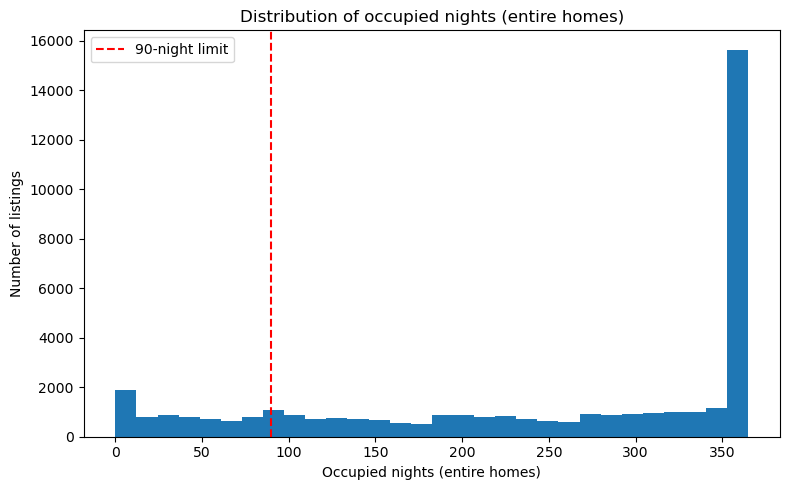

=== Policy Figure 2: top violation boroughs ===


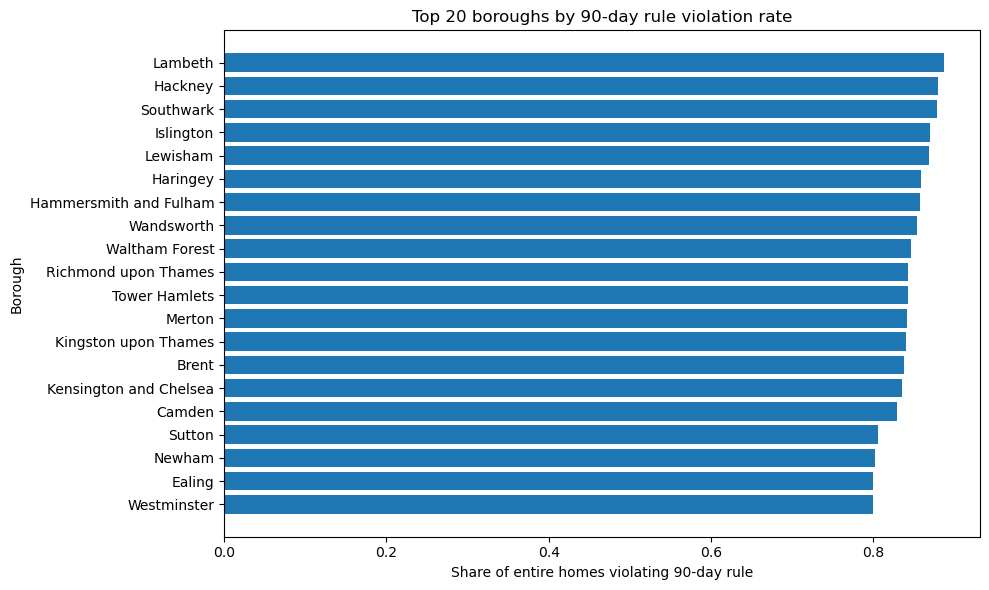

=== Policy Figure 3: share_commercial vs share_violations ===


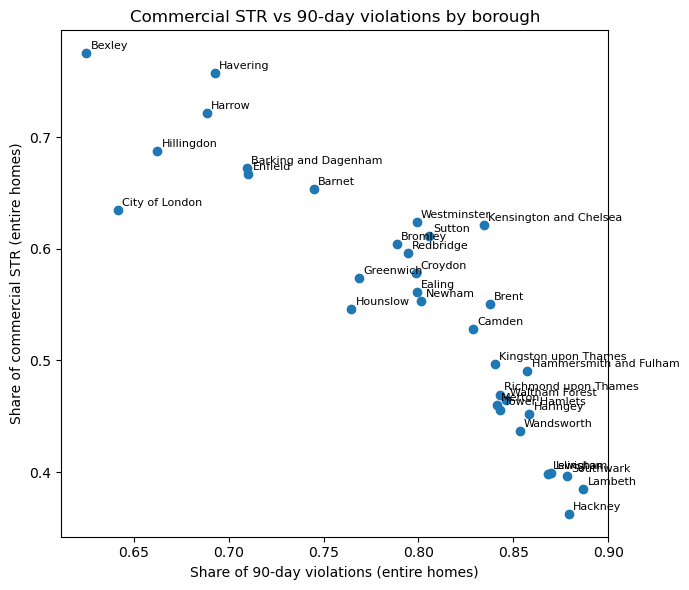

=== Policy Figure 4: nights vs reviews (entire homes) ===


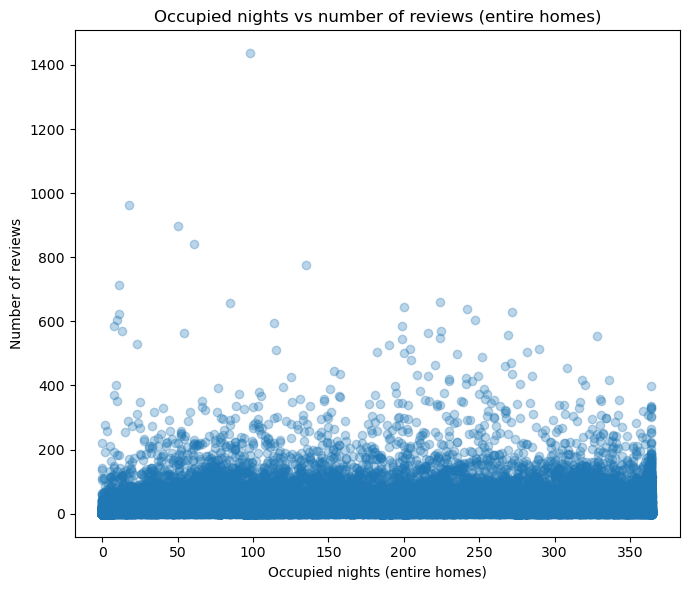

=== Policy Table: top violation listings ===
=== Top 20 entire homes by occupied nights ===
                listing_id      host_id  occupied_nights  available_nights  \
89487  1153541262287529082  559769140.0              365                 0   
37240             43735155  337067729.0              365                 0   
37246             43735271  337067729.0              365                 0   
37245             43735267  337067729.0              365                 0   
37244             43735264  337067729.0              365                 0   
37243             43735257  337067729.0              365                 0   
37242             43735196  337067729.0              365                 0   
37241             43735189  337067729.0              365                 0   
44409             54409337  422898790.0              365                 0   
37239             43735147  338455898.0              365                 0   
27424             30540296  148437518.0           

<Figure size 600x500 with 0 Axes>

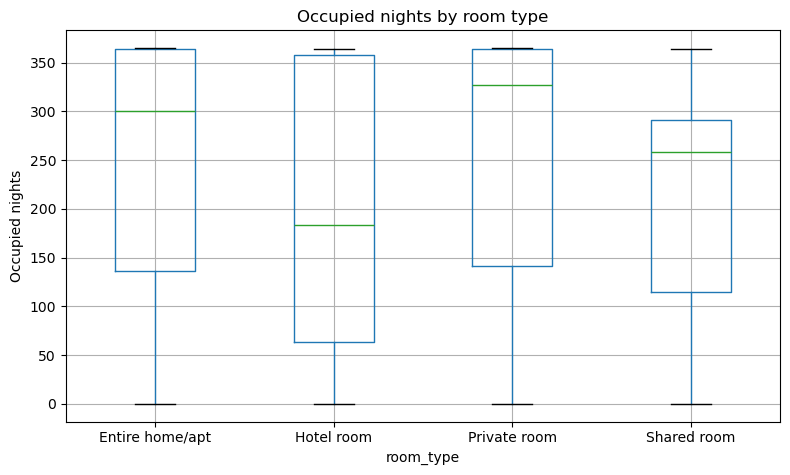

=== Policy analysis done. ===


In [3]:
# ② 政策部分
results_policy = run_policy_from_merged(merged)

=== Commercial Step 1: Entire-home share ===
{'total_listings': 93480, 'n_entire': 40112, 'share_entire': 0.4290971330765939}

=== Commercial Step 2: Host structure ===
Total hosts: 43329
Multi-host share: 0.16704747397816705
Listings controlled by top10% hosts: 0.25297389816003424

=== Commercial Step 3: Availability & hotel-like STR ===
n_entire: 40112
n_commercial_entire: 20331
share_commercial_entire: 50.69%
n_hotel_like_entire: 27801
share_hotel_like_entire: 69.31%
n_legal_but_commercial_entire: 6732
share_legal_but_commercial_entire: 16.78%

=== Commercial Step 4: Commercialisation matrix ===
n_entire_total: 40112
n_entire_only: 15133
n_entire_multi: 4648
n_entire_commercial: 8601
n_entire_multi_commercial: 11730
share_entire_only: 37.73%
share_entire_multi: 11.59%
share_entire_commercial: 21.44%
share_entire_multi_commercial: 29.24%

=== Commercial Step 5: STR revenue estimate ===
   listing_id  str_monthly_est
1       15400       808.000000
2       17402      1700.000000
3     

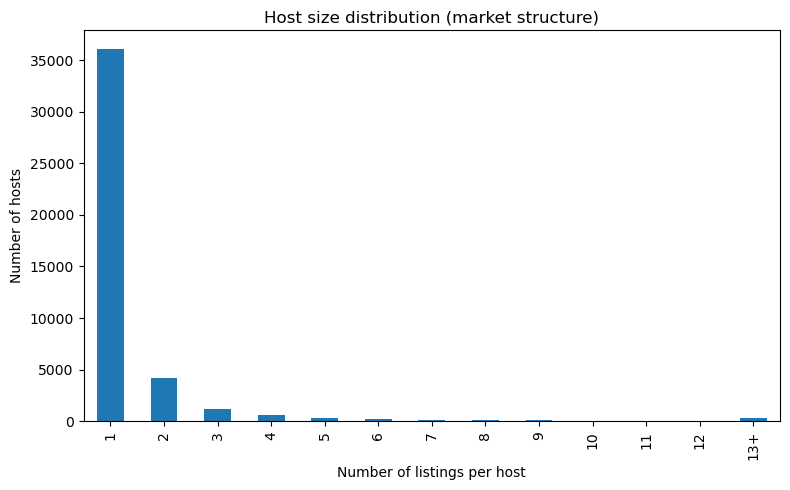

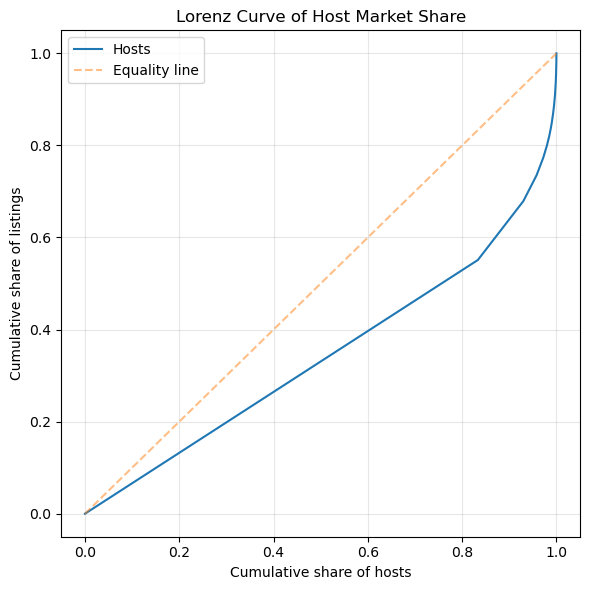

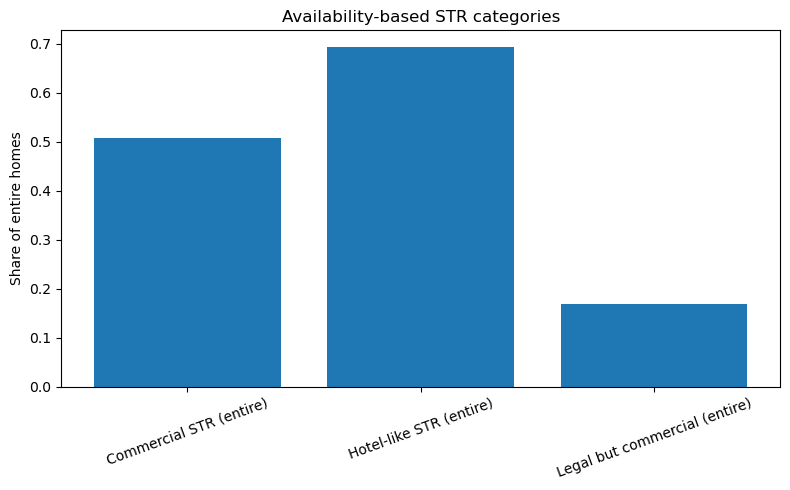

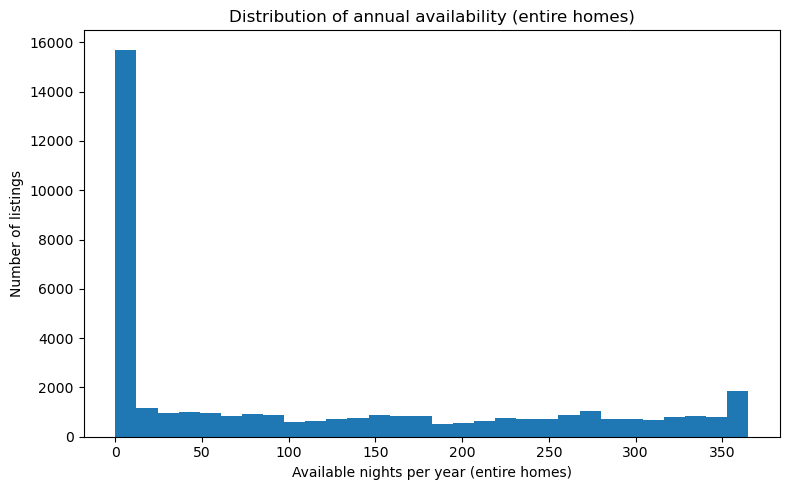

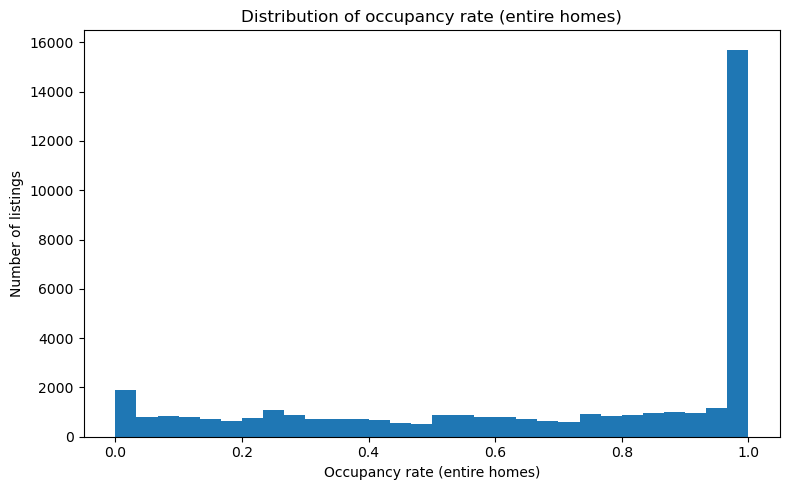

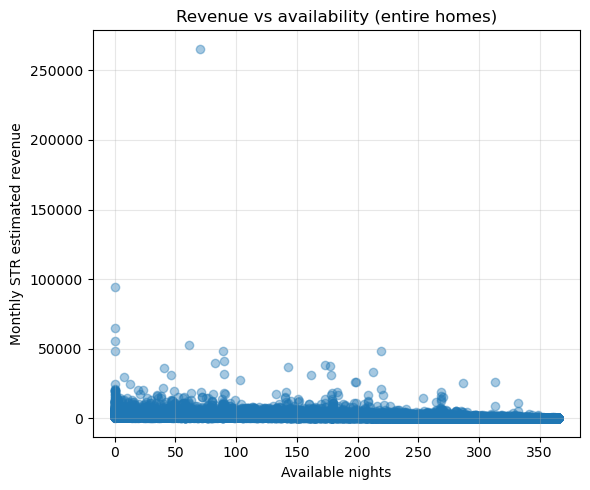


=== Commercial analysis done. ===


In [4]:
# ③ 商业部分
results_commercial = run_commercial_from_merged(
    merged,
    load_rent=True,   # 如果不想加载租金表可以改成 False
    load_stock=True,  # 如果不想算 density 可以改成 False
)

=== Spatial: borough-level summary ===
                borough  n_listings  n_entire  n_commercial_entire  \
0  Barking and Dagenham         419       186                  125   
1                Barnet        1604       949                  620   
2                Bexley         406       160                  124   
3                 Brent        1918      1054                  580   
4               Bromley         606       303                  183   

   share_entire  share_commercial_entire  str_density_per_1000  
0      0.443914                 0.672043             75.062702  
1      0.591646                 0.653319            156.533620  
2      0.394089                 0.775000             28.641975  
3      0.549531                 0.550285             98.927171  
4      0.500000                 0.603960             31.549354  

=== Spatial Figures ===


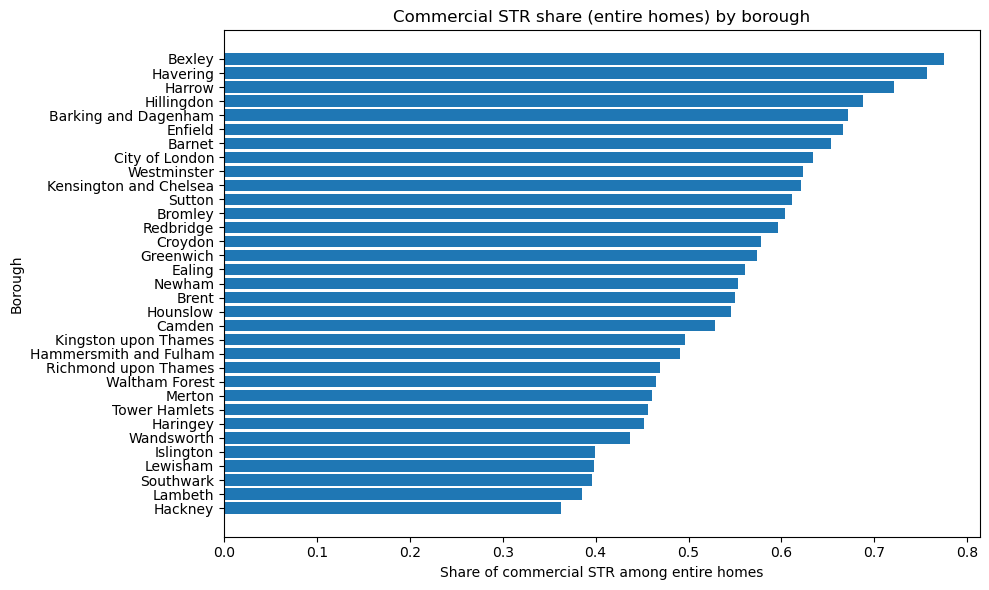

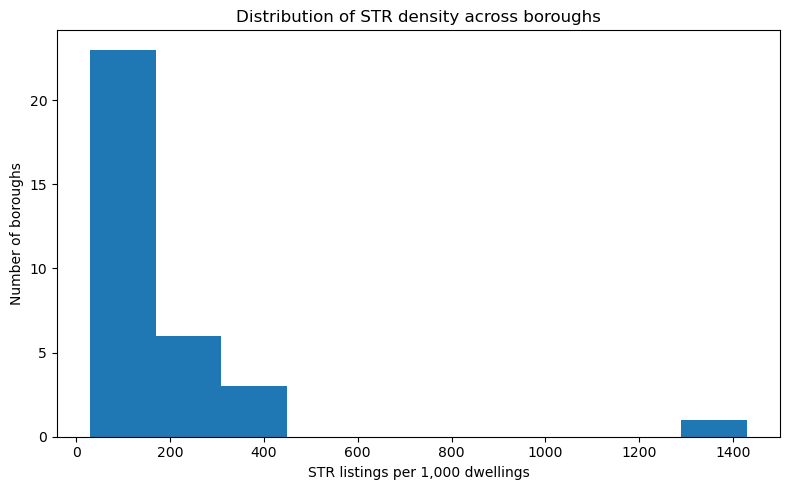

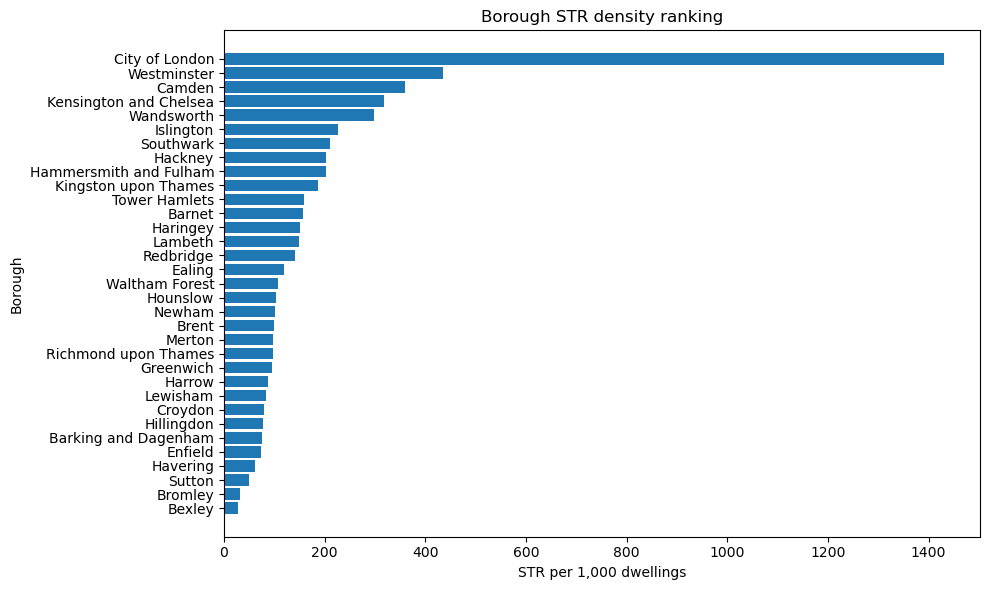

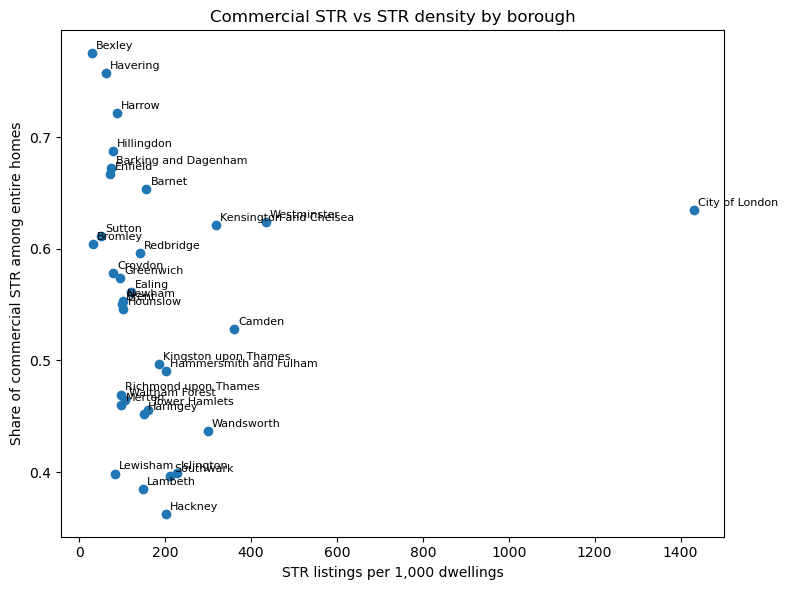


=== Spatial analysis done. ===


In [5]:
# ④ 空间部分（用商业部分算好的 str_density_df）
results_spatial = run_spatial_from_merged(
    merged,
    str_density_df=results_commercial["str_density_df"],
)